# Figure S1: Evaluating inference procedures across model type (linear and Poisson)

In [1]:
import h5py
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os

from networkx.algorithms import community
from scipy.stats import wilcoxon
from uoineuro.coupling_utils import (read_coupling_coefs,
                                     selection_profiles_by_chance,
                                     create_directed_graph)
from uoineuro.utils import tighten_scatter_plot

%matplotlib inline

## Read in fitted models

In [2]:
base_path = os.path.join(os.environ['HOME'], 'fits/uoineuro/coupling')

In [3]:
# consolidate v1 results
v1_results_paths = [os.path.join(base_path, 'pvc11/pvc11_monkey1_coupling.h5'),
                    os.path.join(base_path, 'pvc11/pvc11_monkey2_coupling.h5'),
                    os.path.join(base_path, 'pvc11/pvc11_monkey3_coupling.h5')]
n_v1_fits = len(v1_results_paths)
# read in v1 coupling coefficients
v1_baseline_linear_ccs, v1_uoi_linear_ccs, v1_baseline_poisson_ccs, v1_uoi_poisson_ccs = \
    read_coupling_coefs(v1_results_paths)

In [4]:
# consolidate m1 results
m1_results_paths = [os.path.join(base_path, 'nhp/nhp_indy_20160407_02_coupling.h5'),
                    os.path.join(base_path, 'nhp/nhp_indy_20160411_01_coupling.h5'),
                    os.path.join(base_path, 'nhp/nhp_indy_20160411_02_coupling.h5')]
n_m1_fits = len(m1_results_paths)
# read in m1 coupling coefficients
m1_baseline_linear_ccs, m1_uoi_linear_ccs, m1_baseline_poisson_ccs, m1_uoi_poisson_ccs = \
    read_coupling_coefs(m1_results_paths)

In [5]:
# consolidate coupling coefficients
n_datasets = n_m1_fits + n_v1_fits
baseline_linear_ccs = v1_baseline_linear_ccs + m1_baseline_linear_ccs
baseline_poisson_ccs = v1_baseline_poisson_ccs + m1_baseline_poisson_ccs
uoi_linear_ccs = v1_uoi_linear_ccs + m1_uoi_linear_ccs
uoi_poisson_ccs = v1_uoi_poisson_ccs + m1_uoi_poisson_ccs

In [7]:
# create directed graphs
baseline_linear_graphs = [create_directed_graph(baseline_linear_ccs[idx], weighted=False)
                          for idx in range(n_datasets)]
baseline_poisson_graphs = [create_directed_graph(baseline_poisson_ccs[idx], weighted=False)
                           for idx in range(n_datasets)]
uoi_linear_graphs = [create_directed_graph(uoi_linear_ccs[idx], weighted=False)
                     for idx in range(n_datasets)]
uoi_poisson_graphs = [create_directed_graph(uoi_poisson_ccs[idx], weighted=False)
                      for idx in range(n_datasets)]

## Figure S1a: Selection Profiles by Chance

### Calculate Selection Profile Matching Probability

In [7]:
# baseline selection profiles by chance
v1_baseline_sel_probs = np.concatenate([selection_profiles_by_chance(
    v1_baseline_poisson_ccs[idx],
    v1_baseline_linear_ccs[idx])
    for idx in range(n_v1_fits)])
m1_baseline_sel_probs = np.concatenate([selection_profiles_by_chance(
    m1_baseline_poisson_ccs[idx],
    m1_baseline_linear_ccs[idx])
    for idx in range(n_m1_fits)])
# uoi selection profiles by chance
v1_uoi_sel_probs = np.concatenate([selection_profiles_by_chance(
    v1_uoi_poisson_ccs[idx],
    v1_uoi_linear_ccs[idx])
    for idx in range(n_v1_fits)])
m1_uoi_sel_probs = np.concatenate([selection_profiles_by_chance(
    m1_uoi_poisson_ccs[idx],
    m1_uoi_linear_ccs[idx])
    for idx in range(n_m1_fits)])

### Report Statistics

In [8]:
pvalue = 0.001
print('Fraction of Statistically Significant Profiles:')
print('V1 Baseline: %0.3f' %((v1_baseline_sel_probs < pvalue).sum() / v1_baseline_sel_probs.size))
print('V1 UoI: %0.3f' %((v1_uoi_sel_probs < pvalue).sum() / v1_uoi_sel_probs.size))
print('M1 Baseline: %0.3f' %((m1_baseline_sel_probs < pvalue).sum() / m1_baseline_sel_probs.size))
print('M1 UoI: %0.3f' %((m1_uoi_sel_probs < pvalue).sum() / m1_uoi_sel_probs.size))

Fraction of Statistically Significant Profiles:
V1 Baseline: 0.732
V1 UoI: 0.984
M1 Baseline: 0.995
M1 UoI: 0.995


In [9]:
# compare uoi and baseline selection probabilities with wilcoxon test
v1_pvalue = wilcoxon(
    v1_uoi_sel_probs,
    v1_baseline_sel_probs,
    zero_method='zsplit',
    alternative='less').pvalue
m1_pvalue = wilcoxon(
    m1_uoi_sel_probs,
    m1_baseline_sel_probs,
    zero_method='zsplit',
    alternative='less').pvalue
# print out statistical test p-values
print('Comparing UoI and baseline selection probabilities, V1: ', v1_pvalue)
print('Comparing UoI and baseline selection probabilities, M1: ', m1_pvalue)

Comparing UoI and baseline selection probabilities, V1:  5.547372379808755e-29
Comparing UoI and baseline selection probabilities, M1:  0.9999999186530196


### Plot Distribution of Selection Profile Matching Probabilities

In [10]:
# for plotting, replace zero-values with something very small
v1_baseline_sel_probs_plot = np.copy(v1_baseline_sel_probs)
m1_baseline_sel_probs_plot = np.copy(m1_baseline_sel_probs)
v1_uoi_sel_probs_plot = np.copy(v1_uoi_sel_probs)
m1_uoi_sel_probs_plot = np.copy(m1_uoi_sel_probs)

for sel_probs_plot in [v1_baseline_sel_probs_plot, m1_baseline_sel_probs_plot, v1_uoi_sel_probs_plot, m1_uoi_sel_probs_plot]:
    sel_probs_plot[sel_probs_plot == 0] = 1e-20

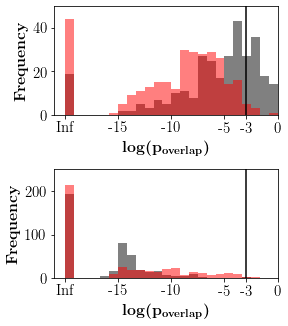

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(4, 5))

# plot v1 selection probabilities on top
bins = np.linspace(-20, 0, 25)
axes[0].hist(np.log10(v1_baseline_sel_probs_plot), bins=bins, color='gray')
axes[0].hist(np.log10(v1_uoi_sel_probs_plot), bins=bins, color='red', alpha=0.5)
# plot m1 selection probabilities on bottom
bins = np.linspace(-20, 0, 25)
axes[1].hist(np.log10(m1_baseline_sel_probs_plot), bins=bins, color='gray')
axes[1].hist(np.log10(m1_uoi_sel_probs_plot), bins=bins, color='red', alpha=0.5)

for ax in axes:
    ax.axvline(np.log10(pvalue), color='k')
    ax.set_xlim([-21, 0])
    ax.set_xticks([-20, -15, -10, -5, -3, 0])
    ax.set_xticklabels(['Inf', -15, -10, -5, -3, 0])
    ax.set_xlabel(r'$\textbf{log(}\mathbf{p_{overlap}}\textbf{)}$', fontsize=16)
    ax.set_ylabel(r'\textbf{Frequency}', fontsize=16)
    ax.tick_params(labelsize=15)
    
axes[0].set_ylim([0, 50])
axes[1].set_ylim([0, 250])

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.savefig('sel_probs_by_change.pdf', bbox_inches='tight')

## Figure S1b: In-degree and Out-degree Distribution

### Calculate Degree Distributions

In [8]:
# baseline in-degrees
baseline_linear_indeg = [np.array(list(dict(baseline_linear_graphs[dataset].in_degree()).values()))
                         for dataset in range(n_datasets)]
v1_baseline_linear_indeg = np.concatenate(baseline_linear_indeg[:n_v1_fits])
m1_baseline_linear_indeg = np.concatenate(baseline_linear_indeg[n_m1_fits:])
baseline_poisson_indeg = [np.array(list(dict(baseline_poisson_graphs[dataset].in_degree()).values()))
                          for dataset in range(n_datasets)]
v1_baseline_poisson_indeg = np.concatenate(baseline_poisson_indeg[:n_v1_fits])
m1_baseline_poisson_indeg = np.concatenate(baseline_poisson_indeg[n_m1_fits:])
# baseline out-degrees
baseline_linear_outdeg = [np.array(list(dict(baseline_linear_graphs[dataset].out_degree()).values()))
                         for dataset in range(n_datasets)]
v1_baseline_linear_outdeg = np.concatenate(baseline_linear_outdeg[:n_v1_fits])
m1_baseline_linear_outdeg = np.concatenate(baseline_linear_outdeg[n_m1_fits:])
baseline_poisson_outdeg = [np.array(list(dict(baseline_poisson_graphs[dataset].out_degree()).values()))
                          for dataset in range(n_datasets)]
v1_baseline_poisson_outdeg = np.concatenate(baseline_poisson_outdeg[:n_v1_fits])
m1_baseline_poisson_outdeg = np.concatenate(baseline_poisson_outdeg[n_m1_fits:])
# uoi in-degrees
uoi_linear_indeg = [np.array(list(dict(uoi_linear_graphs[dataset].in_degree()).values()))
                      for dataset in range(n_datasets)]
v1_uoi_linear_indeg = np.concatenate(uoi_linear_indeg[:n_v1_fits])
m1_uoi_linear_indeg = np.concatenate(uoi_linear_indeg[n_m1_fits:])
uoi_poisson_indeg = [np.array(list(dict(uoi_poisson_graphs[dataset].in_degree()).values()))
                      for dataset in range(n_datasets)]
v1_uoi_poisson_indeg = np.concatenate(uoi_poisson_indeg[:n_v1_fits])
m1_uoi_poisson_indeg = np.concatenate(uoi_poisson_indeg[n_m1_fits:])
# uoi out-degrees
uoi_linear_outdeg = [np.array(list(dict(uoi_linear_graphs[dataset].out_degree()).values()))
                      for dataset in range(n_datasets)]
v1_uoi_linear_outdeg = np.concatenate(uoi_linear_outdeg[:n_v1_fits])
m1_uoi_linear_outdeg = np.concatenate(uoi_linear_outdeg[n_m1_fits:])
uoi_poisson_outdeg = [np.array(list(dict(uoi_poisson_graphs[dataset].out_degree()).values()))
                      for dataset in range(n_datasets)]
v1_uoi_poisson_outdeg = np.concatenate(uoi_poisson_outdeg[:n_v1_fits])
m1_uoi_poisson_outdeg = np.concatenate(uoi_poisson_outdeg[n_m1_fits:])

### Calculate Statistics

In [9]:
# calculate correlations between baseline approaches
v1_baseline_in = np.corrcoef(v1_baseline_linear_indeg, v1_baseline_poisson_indeg)[0, 1]
v1_baseline_out = np.corrcoef(v1_baseline_linear_outdeg, v1_baseline_poisson_outdeg)[0, 1]
m1_baseline_in = np.corrcoef(m1_baseline_linear_indeg, m1_baseline_poisson_indeg)[0, 1]
m1_baseline_out = np.corrcoef(m1_baseline_linear_outdeg, m1_baseline_poisson_outdeg)[0, 1]
# calculate correlations 
v1_uoi_in = np.corrcoef(v1_uoi_linear_indeg, v1_uoi_poisson_indeg)[0, 1]
v1_uoi_out = np.corrcoef(v1_uoi_linear_outdeg, v1_uoi_poisson_outdeg)[0, 1]
m1_uoi_in = np.corrcoef(m1_uoi_linear_indeg, m1_uoi_poisson_indeg)[0, 1]
m1_uoi_out = np.corrcoef(m1_uoi_linear_outdeg, m1_uoi_poisson_outdeg)[0, 1]

In [10]:
print('V1, In-degree, Baseline vs. UoI: %0.3f vs. %0.3f' %(v1_baseline_in, v1_uoi_in))
print('V1, Out-degree, Baseline vs. UoI: %0.3f vs. %0.3f' %(v1_baseline_out, v1_uoi_out))
print('M1, In-degree, Baseline vs. UoI: %0.3f vs. %0.3f' %(m1_baseline_in, m1_uoi_in))
print('M1, Out-degree, Baseline vs. UoI: %0.3f vs. %0.3f' %(m1_baseline_out, m1_uoi_out))

V1, In-degree, Baseline vs. UoI: 0.717 vs. 0.742
V1, Out-degree, Baseline vs. UoI: 0.531 vs. 0.806
M1, In-degree, Baseline vs. UoI: 0.932 vs. 0.969
M1, Out-degree, Baseline vs. UoI: 0.924 vs. 0.918


### Plot Degree Distributions

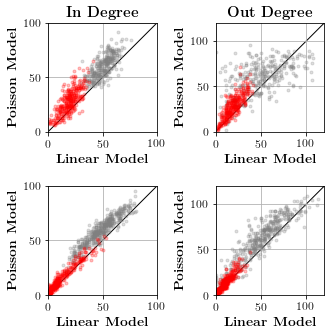

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5),
                         gridspec_kw={'width_ratios': [1, 1]})
# V1, in-degree
axes[0, 0].scatter(
    v1_baseline_linear_indeg,
    v1_baseline_poisson_indeg,
    color='gray',
    marker='.',
    alpha=0.25)   
axes[0, 0].scatter(
    v1_uoi_linear_indeg,
    v1_uoi_poisson_indeg,
    color='r',
    marker='.',
    alpha=0.25) 
# V1, out-degree
axes[0, 1].scatter(
    v1_baseline_linear_outdeg,
    v1_baseline_poisson_outdeg,
    color='gray',
    marker='.',
    alpha=0.25)   
axes[0, 1].scatter(
    v1_uoi_linear_outdeg,
    v1_uoi_poisson_outdeg,
    color='r',
    marker='.',
    alpha=0.25) 
# M1, in-degree
axes[1, 0].scatter(
    m1_baseline_linear_indeg,
    m1_baseline_poisson_indeg,
    color='gray',
    marker='.',
    alpha=0.25)   
axes[1, 0].scatter(
    m1_uoi_linear_indeg,
    m1_uoi_poisson_indeg,
    color='r',
    marker='.',
    alpha=0.25) 
# M1, out-degree
axes[1, 1].scatter(
    m1_baseline_linear_outdeg,
    m1_baseline_poisson_outdeg,
    color='gray',
    marker='.',
    alpha=0.25)   
axes[1, 1].scatter(
    m1_uoi_linear_outdeg,
    m1_uoi_poisson_outdeg,
    color='r',
    marker='.',
    alpha=0.25) 
        
for ax in axes[:, 0]:
    tighten_scatter_plot(ax, bounds=[0, 100],
                         line_kwargs={'color': 'black', 'linewidth': 1})
    ax.set_xticks([0, 50, 100])
    ax.set_yticks(ax.get_xticks())

for ax in axes[:, 1]:
    tighten_scatter_plot(ax, bounds=[0, 120],
                         line_kwargs={'color': 'black', 'linewidth': 1})
    
for ax in axes.ravel():
    ax.set_xticks([0, 50, 100])
    ax.set_yticks(ax.get_xticks())
    ax.set_xlabel(r'\textbf{Linear Model}', fontsize=14)
    ax.set_ylabel(r'\textbf{Poisson Model}', fontsize=14)
    ax.grid('on')
    ax.set_axisbelow(True)
    ax.tick_params(labelsize=12)


axes[0, 0].set_title(r'\textbf{In Degree}', fontsize=15)
axes[0, 1].set_title(r'\textbf{Out Degree}', fontsize=15)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
#plt.savefig('in_out_degree.pdf')

## Figure S1c: Modularity

In [12]:
graphs = [baseline_linear_graphs, baseline_poisson_graphs, uoi_linear_graphs, uoi_poisson_graphs]
n_graphs = len(graphs)
modularity = np.zeros((len(graphs), n_datasets))

for graph_idx, graph in enumerate(graphs):
    for dataset in range(n_datasets):
        comp = community.greedy_modularity_communities(graph[dataset].to_undirected(reciprocal=True))
        modularity[graph_idx, dataset] = community.modularity(
            graph[dataset].to_undirected(reciprocal=True),
            comp)

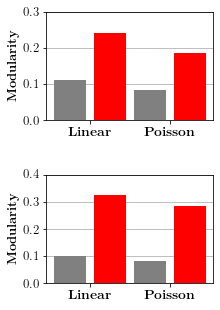

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(3, 5))

axes[0].bar(
    x=np.arange(n_graphs),
    height=[modularity[0, :3].mean(), modularity[2, :3].mean(),
            modularity[1, :3].mean(), modularity[3, :3].mean()],
    color=['gray', 'red', 'gray', 'red'])

axes[0].set_ylim([0, 0.30])
axes[1].bar(
    x=np.arange(n_graphs),
    height=[modularity[0, 3:].mean() + 0.01, modularity[2, 3:].mean(),
            modularity[1, 3:].mean(), modularity[3, 3:].mean()],
    color=['gray', 'red', 'gray', 'red'])

for ax in axes:
    ax.set_ylabel(r'\textbf{Modularity}', fontsize=13)
    ax.tick_params(labelsize=13)
    ax.set_xticks([0.5, 2.5])
    ax.set_xticklabels([r'\textbf{Linear}', r'\textbf{Poisson}'], fontsize=14)
    ax.grid(axis='y')
    ax.set_axisbelow(True)

axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
plt.subplots_adjust(hspace=0.5, wspace=0.45)
plt.savefig('modularity.pdf', bbox_inches='tight')